# Étape 1 — Collecte & organisation du dataset 



1. Importer les dépendances

In [37]:
from dotenv import load_dotenv
import os
import kagglehub
import shutil
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import pandas as pd
import joblib

2. Load kaggle api key from .env file

In [ ]:
# Load .env first
load_dotenv(override=True, verbose=True)

# verify where is the kaggle config dir
print("KAGGLE_CONFIG_DIR:", os.getenv("KAGGLE_CONFIG_DIR"))
# verify where kaggle will cache datasets
print("KAGGLEHUB_CACHE:", os.getenv("KAGGLEHUB_CACHE"))

KAGGLE_CONFIG_DIR: /home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier
KAGGLEHUB_CACHE: /home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier


3. Télécharger le dataset Kaggle avec kagglehub

In [2]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("prithivsakthiur/multilabel-geoscenenet-16k")

print("Path to dataset files:", path)

100%|██████████| 214M/214M [03:27<00:00, 1.08MB/s] 

Extracting files...


Path to dataset files: /home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/datasets/prithivsakthiur/multilabel-geoscenenet-16k/versions/1


4. Déplacer les données du dossier du jeu de données Kaggle installé vers le dossier data

In [5]:
# Entrez le dossier GeoSceneNet16K 
geo_folder = os.path.join(path, "GeoSceneNet16K")

# Le chemin du dossier cible où les dossiers seront déplacés
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "data")
os.makedirs(data_dir, exist_ok=True)  # create if it doesn't exist

# La liste des dossiers à déplacer
folders_to_move = ["Sea or Ocean", "Forest Area", "Desert"]

# Boucle pour déplacer chaque dossier
for folder_name in folders_to_move:
    src_path = os.path.join(geo_folder, folder_name)
    dest_path = os.path.join(data_dir, folder_name)
    
    if os.path.exists(src_path):
        # Supprimer le dossier de destination s'il existe déjà
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.move(src_path, dest_path)
        print(f"Moved '{folder_name}' to '{data_dir}'")
    else:
        print(f"Folder '{folder_name}' does not exist in '{geo_folder}'")

Moved 'Sea or Ocean' to '/home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/data'
Moved 'Forest Area' to '/home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/data'
Moved 'Desert' to '/home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/data'


In [7]:
# supprimer le dossier temporaire téléchargé
kaggle_data_dir = os.path.join(project_root, "datasets")
shutil.rmtree(kaggle_data_dir)

5. Garder et renommer les dossiers selon les classes souhaitées

In [8]:
# Correspondance Anglais -> Français
rename_map = {
    "Sea or Ocean": "mer",
    "Forest Area": "paysage",
    "Desert": "desert"
}

# Rename folders
for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_dir, old_name)
    new_path = os.path.join(data_dir, new_name)
    
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed '{old_name}' → '{new_name}'")
    else:
        print(f"'{old_name}' not found in {data_dir}")

Renamed 'Sea or Ocean' → 'mer'
Renamed 'Forest Area' → 'paysage'
Renamed 'Desert' → 'desert'


6. Renommer les images (mer1.jpg, mer2.jpg, ...)

In [9]:
for cls in rename_map.values():
    folder_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for idx, img in enumerate(images, 1):
        ext = os.path.splitext(img)[1]
        new_name = f"{cls}{idx}{ext}"
        os.rename(os.path.join(folder_path, img), os.path.join(folder_path, new_name))


7. Equilibrage du dataset

In [ ]:
# Nombre d'images maximum à garder
MAX_IMAGES = 2000

# Parcourir chaque sous-dossier
for folder in rename_map.values():
    folder_path = os.path.join(data_dir, folder)

    if os.path.isdir(folder_path):
        # Récupère toutes les images 
        images = [f for f in os.listdir(folder_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        count = len(images)

        # Supprime aléatoirement si plus que MAX_IMAGES
        if count > MAX_IMAGES:
            to_delete = count - MAX_IMAGES
            delete_samples = random.sample(images, to_delete)

            for img in delete_samples:
                os.remove(os.path.join(folder_path, img))



mer: 2274 images
paysage: 2271 images
desert: 2000 images


In [ ]:
# Verifier le nombre d'images dans chaque dossier
for folder in rename_map.values():
    folder_path = os.path.join(data_dir, folder)

    if os.path.isdir(folder_path):
        # Récupère toutes les images 
        images = [f for f in os.listdir(folder_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        count = len(images)
        print(f"{folder}: {count} images")

mer: 2000 images
paysage: 2000 images
desert: 2000 images


8. Vérification et redimensionnement à 128x128

In [16]:
def check_and_resize(data_dir, classes, size=(128,128)):
    for cls in classes:
        folder = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        valid_images = []
        for img_name in images:
            img_path = os.path.join(folder, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Vérifie la lisibilité
                # Redimensionnement
                img = Image.open(img_path).convert('RGB')
                img = img.resize(size)
                img.save(img_path)
                valid_images.append(img_name)
            except Exception as e:
                print(f"Image corrompue : {img_path}")
        print(f"{cls}: {len(valid_images)} images valides")

# Utiliser la bonne liste de classes françaises :
classes = rename_map.values()
check_and_resize(data_dir, classes)


mer: 2000 images valides
paysage: 2000 images valides
desert: 2000 images valides


# Étape 2 — Exploration et visualisation

1. Sélectionner une image par classe

In [9]:
sample_images = {}
for cls in classes:
    folder = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images[cls] = random.choice(images)

2. Obtenir l'histogramme RGB

In [10]:
def get_rgb_histograms(img_bgr):
    hist_list = []
    for i in range(3):  # BGR channels
        hist = cv2.calcHist([img_bgr], [i], None, [16], [0,256])
        hist = hist.ravel() / hist.sum()  # Normalisation (somme=1)
        hist_list.append(hist)
    return hist_list

3. Obtenir l'histogramme HSV

In [11]:
def get_hsv_histograms(img_bgr):
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    bins = [36, 16, 16]
    ranges = [(0,180), (0,256), (0,256)]
    hsv_hist = []
    for i, b, rng in zip(range(3), bins, ranges):
        hist = cv2.calcHist([img_hsv], [i], None, [b], [rng[0], rng[1]])
        hist = hist.ravel() / hist.sum()
        hsv_hist.append(hist)
    return hsv_hist, img_hsv

4. Subplot combiné image + RGB + HSV

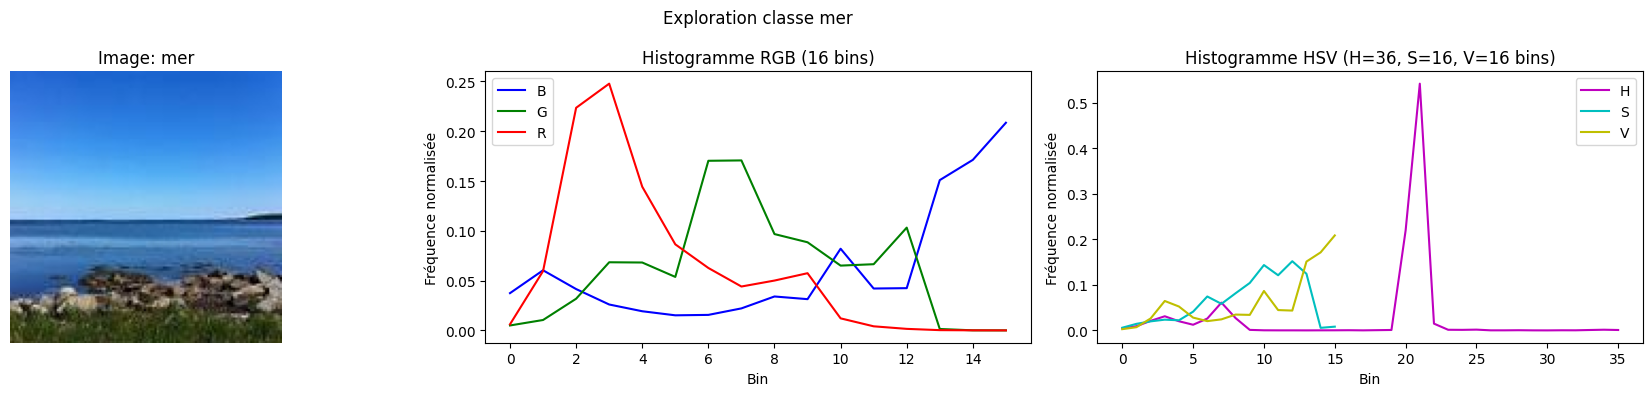

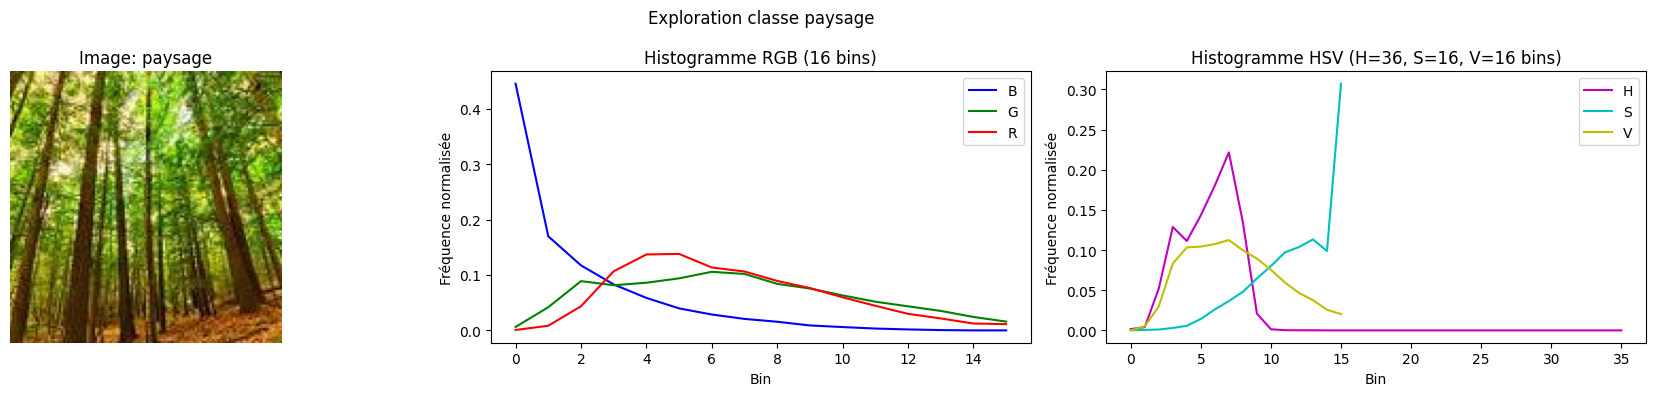

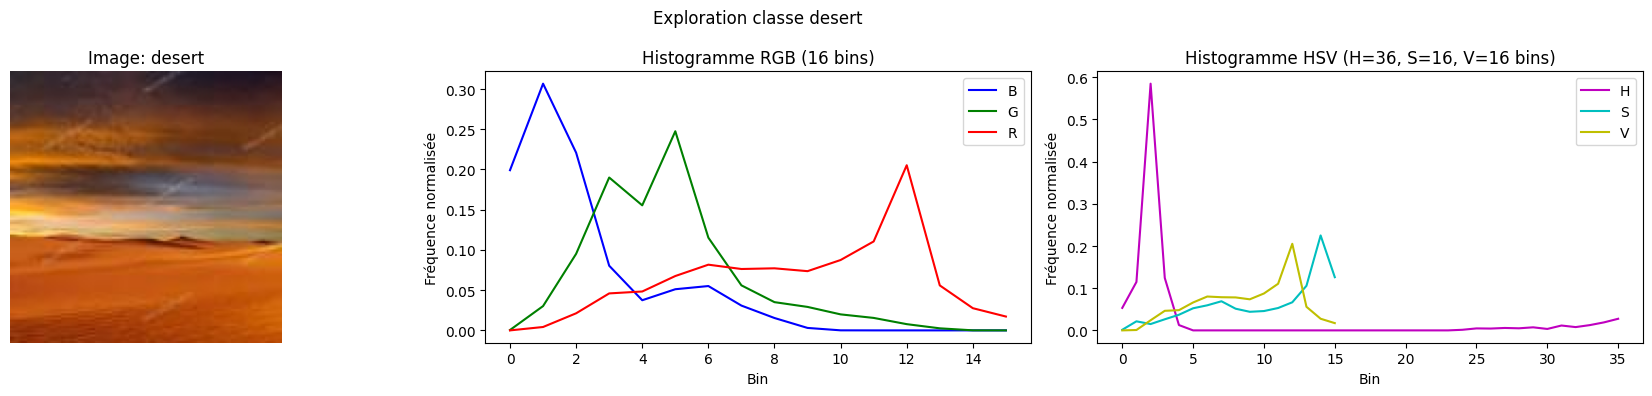

In [12]:
for cls in classes:
    img_path = os.path.join(data_dir, cls, sample_images[cls])
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    rgb_hist = get_rgb_histograms(img_bgr)
    hsv_hist, img_hsv = get_hsv_histograms(img_bgr)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    axs[0].imshow(img_rgb)
    axs[0].set_title(f'Image: {cls}')
    axs[0].axis('off')

    # RGB
    for i, c in enumerate(['b', 'g', 'r']):
        axs[1].plot(np.arange(16), rgb_hist[i], color=c, label=c.upper())
    axs[1].set_title('Histogramme RGB (16 bins)')
    axs[1].set_xlabel('Bin')
    axs[1].set_ylabel('Fréquence normalisée')
    axs[1].legend()

    # HSV
    hsv_bin_sizes = [36, 16, 16]
    hsv_labels = ['H', 'S', 'V']
    hsv_colors = ['m', 'c', 'y']
    for i in range(3):
        axs[2].plot(np.arange(hsv_bin_sizes[i]), hsv_hist[i], color=hsv_colors[i], label=hsv_labels[i])
    axs[2].set_title('Histogramme HSV (H=36, S=16, V=16 bins)')
    axs[2].set_xlabel('Bin')
    axs[2].set_ylabel('Fréquence normalisée')
    axs[2].legend()
    plt.suptitle(f'Exploration classe {cls}')
    plt.tight_layout()
    plt.show()


5. Moyennes/écarts-types HSV pour chaque image

In [13]:
for cls in classes:
    img_path = os.path.join(data_dir, cls, sample_images[cls])
    img_bgr = cv2.imread(img_path)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = [img_hsv[...,i].astype(np.float32) for i in range(3)]
    print(f"Classe {cls} — Image {sample_images[cls]}")
    print(f"Moyenne H : {np.mean(h):.2f} / écarts-type  = {np.std(h):.2f}")
    print(f"Moyenne S : {np.mean(s):.2f} / écarts-type  = {np.std(s):.2f}")
    print(f"Moyenne V : {np.mean(v):.2f} / écarts-type = {np.std(v):.2f}\n")


Classe mer — Image mer840.jpg
Moyenne H : 89.27 / écarts-type  = 32.81
Moyenne S : 155.88 / écarts-type  = 49.95
Moyenne V : 180.69 / écarts-type = 67.03

Classe paysage — Image paysage1278.jpg
Moyenne H : 29.85 / écarts-type  = 9.33
Moyenne S : 202.25 / écarts-type  = 48.19
Moyenne V : 126.08 / écarts-type = 52.33

Classe desert — Image desert562.jpeg
Moyenne H : 27.92 / écarts-type  = 47.20
Moyenne S : 174.61 / écarts-type  = 64.81
Moyenne V : 150.69 / écarts-type = 52.65



# Étape 3 — Intervalles de couleurs & vecteurs de features 

1. Définir les intervalles de teintes dominantes 

In [2]:
# Intervalles de teintes H basés sur les histogrammes de l'étape 2
hue_ranges = {
    'mer': (65, 100),
    'paysage': (25, 35),
    'desert': (30, 60)
}

2. Fonction extract_color_features

In [3]:
def extract_color_features(img_path):
    img = cv2.imread(img_path)
    
    # RGB histograms + stats
    rgb_hists = []
    rgb_stats = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0,256])
        hist = hist.ravel() / hist.sum()
        rgb_hists.append(hist)
        rgb_stats.extend([img[...,i].mean(), img[...,i].std()])
    rgb_features = np.concatenate(rgb_hists + [rgb_stats])
    
    # HSV histograms + stats + hue ratios
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_bins = [36, 16, 16]
    hsv_ranges = [(0,180), (0,256), (0,256)]
    hsv_hists = []
    hsv_stats = []
    for i, b, rng in zip(range(3), hsv_bins, hsv_ranges):
        hist = cv2.calcHist([img_hsv], [i], None, [b], [rng[0], rng[1]])
        hist = hist.ravel() / hist.sum()
        hsv_hists.append(hist)
        hsv_stats.extend([img_hsv[...,i].mean(), img_hsv[...,i].std()])
    
    # Hue ratios
    h_channel = img_hsv[...,0]
    total_pixels = h_channel.size
    hue_ratios = []
    for cls, (h_min, h_max) in hue_ranges.items():
        ratio = np.sum((h_channel >= h_min) & (h_channel < h_max)) / total_pixels
        hue_ratios.append(ratio)
    
    hsv_features = np.concatenate(hsv_hists + [hsv_stats, hue_ratios])
    
    return rgb_features, hsv_features


3. Construire X_rgb, X_hsv, y

In [4]:
classes = ['mer', 'paysage', 'desert']
label_map = {'mer': 0, 'paysage': 1, 'desert': 2}

X_rgb_list = []
X_hsv_list = []
y_list = []

for cls in classes:
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    data_dir = os.path.join(project_root, "data")
    folder = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_name in images:
        img_path = os.path.join(folder, img_name)
        rgb_feat, hsv_feat = extract_color_features(img_path)
        X_rgb_list.append(rgb_feat)
        X_hsv_list.append(hsv_feat)
        y_list.append(label_map[cls])

X_rgb = np.array(X_rgb_list)
X_hsv = np.array(X_hsv_list)
y = np.array(y_list)


4. Appliquer StandardScaler

In [5]:
scaler_rgb = StandardScaler()
X_rgb_scaled = scaler_rgb.fit_transform(X_rgb)

scaler_hsv = StandardScaler()
X_hsv_scaled = scaler_hsv.fit_transform(X_hsv)

5. Vérification et aperçu

In [6]:
print(f"X_rgb.shape: {X_rgb.shape}")
print(f"X_hsv.shape: {X_hsv.shape}")
print(f"y.shape: {y.shape}")
print(f"\nAperçu X_rgb (première ligne):\n{X_rgb_scaled[0]}")
print(f"\nAperçu X_hsv (première ligne):\n{X_hsv_scaled[0]}")
print(f"\nAperçu y (10 premiers labels): {y[:10]}")

X_rgb.shape: (6000, 54)
X_hsv.shape: (6000, 77)
y.shape: (6000,)

Aperçu X_rgb (première ligne):
[-0.13769874  1.28716805 -0.52281007 -1.06210707 -1.08053813 -1.07456679
 -0.95557607 -0.71114204 -0.43290759 -0.30921684 -0.3507309   0.34479181
  1.14881772  1.92403002  1.66013552 -0.275729    0.33065081  2.32774169
 -0.11290007 -0.98917894 -1.2789728  -1.36974345 -1.25992897 -1.01047267
 -0.79956264 -0.86418911 -0.19310367  0.74869465  1.06893476  2.43048054
  0.79403336 -0.40304493  0.13441561  2.11834566 -0.18506088 -0.9627293
 -1.2006811  -1.2341705  -1.08686916 -0.82774245 -0.72408581 -0.7455996
  0.23246745  0.74486354  1.10081111  1.64991366  0.20062389 -0.46179158
  0.70563981  1.99574936  0.3613892   2.48582031  0.1643265   2.02763658]

Aperçu X_hsv (première ligne):
[-2.92371537e-01 -4.96551083e-01 -6.23597250e-01 -6.39190641e-01
 -4.50180881e-01 -2.90464190e-01 -5.16514332e-02 -2.38314563e-01
 -4.02793281e-01 -3.62645105e-01 -3.61639920e-01 -3.10944446e-01
 -3.27635811e-01 -3.

# Étape 4 — Split, pipeline & entraînement SVM 

1. Split train/test (80/20 stratifié)

In [8]:
# Split train/test avec stratification
X_train_rgb, X_test_rgb, y_train, y_test = train_test_split(
    X_rgb, y, test_size=0.2, random_state=42, stratify=y
)

X_train_hsv, X_test_hsv, _, _ = train_test_split(
    X_hsv, y, test_size=0.2, random_state=42, stratify=y
)

print("="*80)
print("SPLIT TRAIN/TEST")
print("="*80)
print(f"Train: {X_train_rgb.shape[0]} images")
print(f"Test: {X_test_rgb.shape[0]} images")
print(f"Distribution train: {np.bincount(y_train)}")
print(f"Distribution test: {np.bincount(y_test)}")


SPLIT TRAIN/TEST
Train: 4800 images
Test: 1200 images
Distribution train: [1600 1600 1600]
Distribution test: [400 400 400]


2. Construction des pipelines

In [9]:
# Pipeline RGB: StandardScaler → PCA(0.95) → SVC(rbf)
pipeline_rgb = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(kernel='rbf'))
])

# Pipeline HSV: StandardScaler → PCA(0.95) → SVC(rbf)
pipeline_hsv = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(kernel='rbf'))
])


3. GridSearchCV pour RGB

In [11]:
# Grille d'hyperparamètres
param_grid = {
    'svc__C': [1, 10, 100],
    'svc__gamma': [1e-3, 1e-2, 1e-1]
}


# GridSearch pour RGB avec 5-fold CV
grid_rgb = GridSearchCV(
    pipeline_rgb,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_rgb.fit(X_train_rgb, y_train)

print(f"\n✓ Meilleurs hyperparamètres RGB:")
print(f"  C = {grid_rgb.best_params_['svc__C']}")
print(f"  gamma = {grid_rgb.best_params_['svc__gamma']}")
print(f"  Score validation croisée: {grid_rgb.best_score_:.4f}")
print(f"  Composantes PCA: {grid_rgb.best_estimator_.named_steps['pca'].n_components_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.4s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.4s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.9s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.0s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   2.8s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.4s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   2.0s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.1s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.3s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.4s
[CV] END ...........................svc__C=1, svc__gamma=0.1; total time=   2.8s
[CV] END ...........................svc__C=1, svc

4. GridSearchCV pour HSV

In [12]:
# GridSearch pour HSV avec 5-fold CV
grid_hsv = GridSearchCV(
    pipeline_hsv,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_hsv.fit(X_train_hsv, y_train)

print(f"\n✓ Meilleurs hyperparamètres HSV:")
print(f"  C = {grid_hsv.best_params_['svc__C']}")
print(f"  gamma = {grid_hsv.best_params_['svc__gamma']}")
print(f"  Score validation croisée: {grid_hsv.best_score_:.4f}")
print(f"  Composantes PCA: {grid_hsv.best_estimator_.named_steps['pca'].n_components_}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.4s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.5s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.6s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   2.1s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.0s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.3s
[CV] END .........................svc__C=1, svc__gamma=0.001; total time=   1.5s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.7s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.3s
[CV] END ..........................svc__C=1, svc__gamma=0.01; total time=   1.5s
[CV] END ...........................svc__C=1, svc__gamma=0.1; total time=   3.1s
[CV] END ...........................svc__C=1, svc

5. Évaluation sur le test set (RGB)

In [13]:
# Prédictions RGB
y_pred_rgb = grid_rgb.predict(X_test_rgb)
acc_rgb = accuracy_score(y_test, y_pred_rgb)
cm_rgb = confusion_matrix(y_test, y_pred_rgb)
report_rgb = classification_report(y_test, y_pred_rgb, target_names=classes, digits=4)

print(f"Accuracy test RGB: {acc_rgb:.4f}")
print("\nMatrice de confusion RGB:")
print(cm_rgb)
print("\nRapport de classification RGB:")
print(report_rgb)


Accuracy test RGB: 0.8775

Matrice de confusion RGB:
[[345  20  35]
 [ 19 370  11]
 [ 44  18 338]]

Rapport de classification RGB:
              precision    recall  f1-score   support

         mer     0.8456    0.8625    0.8540       400
     paysage     0.9069    0.9250    0.9158       400
      desert     0.8802    0.8450    0.8622       400

    accuracy                         0.8775      1200
   macro avg     0.8776    0.8775    0.8773      1200
weighted avg     0.8776    0.8775    0.8773      1200



6. Évaluation sur le test set (HSV)

In [14]:
# Prédictions HSV
y_pred_hsv = grid_hsv.predict(X_test_hsv)
acc_hsv = accuracy_score(y_test, y_pred_hsv)
cm_hsv = confusion_matrix(y_test, y_pred_hsv)
report_hsv = classification_report(y_test, y_pred_hsv, target_names=classes, digits=4)

print(f"Accuracy test HSV: {acc_hsv:.4f}")
print("\nMatrice de confusion HSV:")
print(cm_hsv)
print("\nRapport de classification HSV:")
print(report_hsv)


Accuracy test HSV: 0.8850

Matrice de confusion HSV:
[[346  17  37]
 [ 20 368  12]
 [ 39  13 348]]

Rapport de classification HSV:
              precision    recall  f1-score   support

         mer     0.8543    0.8650    0.8596       400
     paysage     0.9246    0.9200    0.9223       400
      desert     0.8766    0.8700    0.8733       400

    accuracy                         0.8850      1200
   macro avg     0.8852    0.8850    0.8851      1200
weighted avg     0.8852    0.8850    0.8851      1200



7. Visualisation des matrices de confusion

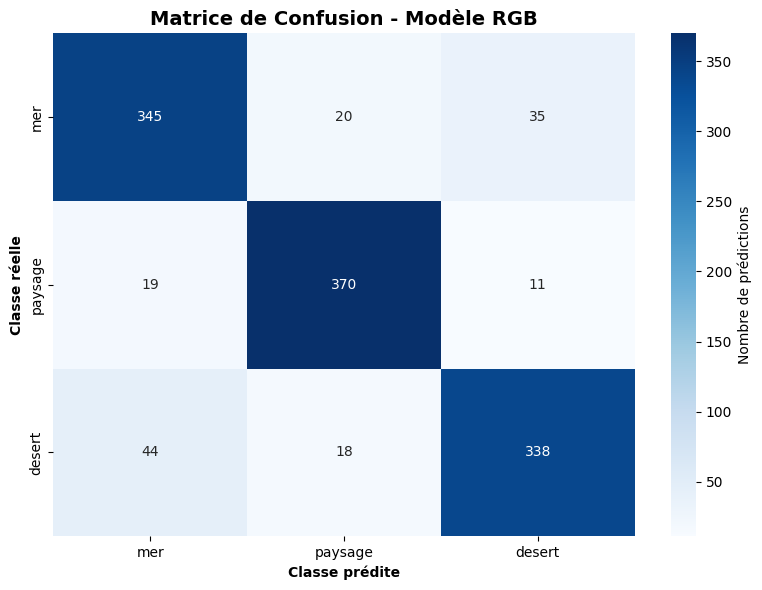

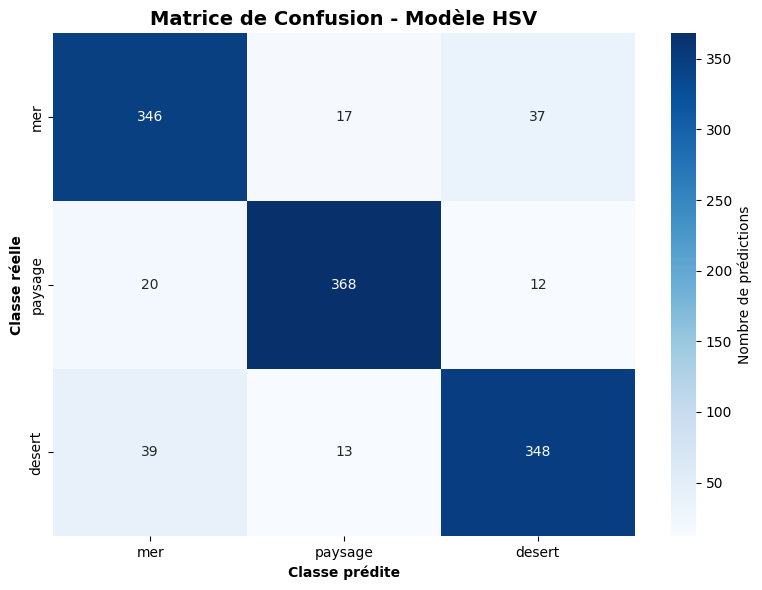

In [16]:
def plot_confusion_matrix(cm, classes, title, filename):
    """Affiche et sauvegarde la matrice de confusion"""
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Nombre de prédictions'})
    ax.set_xlabel('Classe prédite', fontweight='bold')
    ax.set_ylabel('Classe réelle', fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'figures/{filename}', dpi=150, bbox_inches='tight')
    plt.show()

# Visualiser les matrices
plot_confusion_matrix(cm_rgb, classes, 
                     'Matrice de Confusion - Modèle RGB', 
                     'confusion_matrix_rgb.png')

plot_confusion_matrix(cm_hsv, classes, 
                     'Matrice de Confusion - Modèle HSV', 
                     'confusion_matrix_hsv.png')


9. Comparaison RGB vs HSV

In [17]:
comparison = {
    'Modèle': ['RGB', 'HSV'],
    'Accuracy Test': [acc_rgb, acc_hsv],
    'C optimal': [grid_rgb.best_params_['svc__C'], grid_hsv.best_params_['svc__C']],
    'Gamma optimal': [grid_rgb.best_params_['svc__gamma'], grid_hsv.best_params_['svc__gamma']],
    'Score CV': [grid_rgb.best_score_, grid_hsv.best_score_],
    'Dimensions PCA': [grid_rgb.best_estimator_.named_steps['pca'].n_components_,
                       grid_hsv.best_estimator_.named_steps['pca'].n_components_]
}

df_comparison = pd.DataFrame(comparison)
print(df_comparison.to_string(index=False))

# Afficher le gagnant
if acc_hsv > acc_rgb:
    gain = (acc_hsv - acc_rgb) * 100
    print(f"\n🏆 HSV gagne avec {acc_hsv:.4f} (gain: +{gain:.2f}%)")
else:
    gain = (acc_rgb - acc_hsv) * 100
    print(f"\n🏆 RGB gagne avec {acc_rgb:.4f} (gain: +{gain:.2f}%)")


Modèle  Accuracy Test  C optimal  Gamma optimal  Score CV  Dimensions PCA
   RGB         0.8775         10          0.010  0.866875              31
   HSV         0.8850        100          0.001  0.879375              45

🏆 HSV gagne avec 0.8850 (gain: +0.75%)


10. Analyse des erreurs

In [18]:
def analyze_confusion_pairs(cm, classes, model_name):
    """Identifie les paires de classes les plus confondues"""
    print(f"\n🔍 Analyse des confusions - {model_name}:")
    print("-" * 60)
    
    confusions = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j and cm[i, j] > 0:
                confusions.append((classes[i], classes[j], cm[i, j]))
    
    confusions.sort(key=lambda x: x[2], reverse=True)
    
    if confusions:
        for real, pred, count in confusions[:3]:
            percentage = (count / cm.sum(axis=1)[classes.index(real)]) * 100
            print(f"  • {real} → {pred}: {count} erreurs ({percentage:.2f}%)")
    else:
        print("  Aucune confusion (classification parfaite)")
    
    return confusions

confusions_rgb = analyze_confusion_pairs(cm_rgb, classes, "RGB")
confusions_hsv = analyze_confusion_pairs(cm_hsv, classes, "HSV")



🔍 Analyse des confusions - RGB:
------------------------------------------------------------
  • desert → mer: 44 erreurs (11.00%)
  • mer → desert: 35 erreurs (8.75%)
  • mer → paysage: 20 erreurs (5.00%)

🔍 Analyse des confusions - HSV:
------------------------------------------------------------
  • desert → mer: 39 erreurs (9.75%)
  • mer → desert: 37 erreurs (9.25%)
  • paysage → mer: 20 erreurs (5.00%)


11. Sauvegarde des modèles

In [19]:
# Sauvegarder les meilleurs modèles
joblib.dump(grid_rgb.best_estimator_, 'models/best_model_rgb.pkl')
joblib.dump(grid_hsv.best_estimator_, 'models/best_model_hsv.pkl')


['models/best_model_hsv.pkl']

# Étape 5 — Baselines & contrôle 

1. Baseline : Règle Hue

In [23]:
# Règle Hue : prédire la classe selon le ratio de pixels dans chaque bande de teinte
def classify_by_hue_from_features(hsv_features):
    # Les 3 dernières valeurs de hsv_features sont les ratios (mer, paysage, désert)
    ratios = hsv_features[-3:]
    predicted_class = np.argmax(ratios)
    return predicted_class

# Appliquer la règle Hue sur le test set
y_pred_hue = np.array([classify_by_hue_from_features(x) for x in X_test_hsv])

2. Calcul des scores pour les 3 méthodes

In [24]:
# Accuracy et Macro-F1 pour chaque méthode
acc_hue = accuracy_score(y_test, y_pred_hue)
f1_macro_hue = f1_score(y_test, y_pred_hue, average='macro')

acc_rgb = accuracy_score(y_test, y_pred_rgb)
f1_macro_rgb = f1_score(y_test, y_pred_rgb, average='macro')

acc_hsv = accuracy_score(y_test, y_pred_hsv)
f1_macro_hsv = f1_score(y_test, y_pred_hsv, average='macro')

3. Tableau comparatif

In [25]:
df_comparison = pd.DataFrame({
    'Méthode': ['Règle Hue', 'SVM RGB', 'SVM HSV'],
    'Accuracy': [acc_hue, acc_rgb, acc_hsv],
    'Macro F1-Score': [f1_macro_hue, f1_macro_rgb, f1_macro_hsv]
})

print(df_comparison.to_string(index=False))

  Méthode  Accuracy  Macro F1-Score
Règle Hue  0.354167        0.333827
  SVM RGB  0.877500        0.877349
  SVM HSV  0.885000        0.885069


4. Identification de 2–3 images pièges

In [26]:
# Cas où SVM HSV est correct mais Règle Hue se trompe
svm_correct_hue_wrong_hsv = (y_pred_hsv == y_test) & (y_pred_hue != y_test)
trap_indices = np.where(svm_correct_hue_wrong_hsv)[0][:3]

for idx in trap_indices:
    print(f"\nImage test #{idx}:")
    print(f"  Classe réelle: {classes[y_test[idx]]}")
    print(f"  Règle Hue prédit: {classes[y_pred_hue[idx]]}")
    print(f"  SVM HSV prédit: {classes[y_pred_hsv[idx]]} ✓")
    print(f"  Ratios Hue: mer={X_test_hsv[idx, -3]:.3f}, paysage={X_test_hsv[idx, -2]:.3f}, désert={X_test_hsv[idx, -1]:.3f}")



Image test #1:
  Classe réelle: desert
  Règle Hue prédit: mer
  SVM HSV prédit: desert ✓
  Ratios Hue: mer=0.023, paysage=0.012, désert=0.018

Image test #2:
  Classe réelle: paysage
  Règle Hue prédit: desert
  SVM HSV prédit: paysage ✓
  Ratios Hue: mer=0.127, paysage=0.060, désert=0.775

Image test #3:
  Classe réelle: desert
  Règle Hue prédit: paysage
  SVM HSV prédit: desert ✓
  Ratios Hue: mer=0.005, paysage=0.155, désert=0.036


# Étape 6 — Test les modèles sur une nouvelle image (hors dataset) 

1. Charger une image externe et appliquer les prétraitements

In [33]:
external_img_path = os.path.join(os.getcwd(), "figures", "new_Image.jpg")

# Charger et redimensionner l'image
img = cv2.imread(external_img_path)
img_resized = cv2.resize(img, (128, 128))


2. Extraire les features HSV

In [34]:
# Réutiliser la fonction extract_color_features déjà définie
_, hsv_features = extract_color_features(external_img_path)
hsv_features = hsv_features.reshape(1, -1)

3. Charger le modèle SVM HSV et prédire

In [35]:
best_model_hsv = joblib.load('models/best_model_hsv.pkl')

# Prédire la classe
pred_class_idx = best_model_hsv.predict(hsv_features)[0]
pred_class = classes[pred_class_idx]


4. Afficher l’image et la prédiction

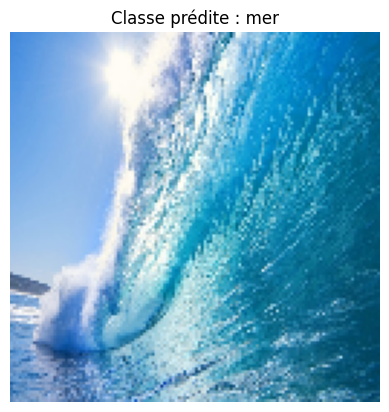

Classe prédite pour l'image externe : mer


In [36]:
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Classe prédite : {pred_class}")
plt.show()

print(f"Classe prédite pour l'image externe : {pred_class}")

# Étape 7 — Validation multi-métriques & rapport final 

1. Calcul des métriques multi-classes (RGB et HSV)

In [38]:
# RGB
acc_rgb = accuracy_score(y_test, y_pred_rgb)
precision_macro_rgb = precision_score(y_test, y_pred_rgb, average='macro')
recall_macro_rgb = recall_score(y_test, y_pred_rgb, average='macro')
f1_macro_rgb = f1_score(y_test, y_pred_rgb, average='macro')

# HSV
acc_hsv = accuracy_score(y_test, y_pred_hsv)
precision_macro_hsv = precision_score(y_test, y_pred_hsv, average='macro')
recall_macro_hsv = recall_score(y_test, y_pred_hsv, average='macro')
f1_macro_hsv = f1_score(y_test, y_pred_hsv, average='macro')


2. Tableau récapitulatif

In [39]:
df_multi_metrics = pd.DataFrame({
    'Modèle': ['RGB', 'HSV'],
    'Accuracy': [acc_rgb, acc_hsv],
    'Macro-Precision': [precision_macro_rgb, precision_macro_hsv],
    'Macro-Recall': [recall_macro_rgb, recall_macro_hsv],
    'Macro-F1': [f1_macro_rgb, f1_macro_hsv]
})

print(df_multi_metrics.to_string(index=False))

Modèle  Accuracy  Macro-Precision  Macro-Recall  Macro-F1
   RGB    0.8775         0.877553        0.8775  0.877349
   HSV    0.8850         0.885173        0.8850  0.885069


3. Matrices de confusion 

In [40]:
print("Matrice de confusion RGB :\n", cm_rgb)
print("Matrice de confusion HSV :\n", cm_hsv)

Matrice de confusion RGB :
 [[345  20  35]
 [ 19 370  11]
 [ 44  18 338]]
Matrice de confusion HSV :
 [[346  17  37]
 [ 20 368  12]
 [ 39  13 348]]
